In [ ]:
# default_exp geoms

# Geo-Data Intake and Operations

> This notebook was made to demonstrate how to work with geographic data.

This Coding Notebook is the __third__ in a series.

An Interactive version can be found here <a href="https://colab.research.google.com/github/karpatic/dataplay/blob/master/notebooks/03_Map_Basics_Intake_and_Operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>.


This colab and more can be found on our [webpage](https://karpatic.github.io/dataplay/). 

- Content covered in previous tutorials will be used in later tutorials. 

- __New code and or  information *should* have explanations and or descriptions__ attached. 

- Concepts or code covered in previous tutorials will be used without being explaining in entirety.

- __If content can not be found in the current tutorial and is not covered in previous tutorials, please let me know.__

- This notebook has been optimized for Google Colabs ran on a Chrome Browser. 

- Statements found in the index page on view expressed, responsibility, errors and ommissions, use at risk, and licensing  extend throughout the tutorial.

## About this Tutorial: 

### Whats Inside?

#### __The Tutorial__

In this notebook, the basics of working with geographic data are introduced.

- Reading in data (points/ geoms)
-- Convert lat/lng columns to point coordinates
-- Geocoding address to coordinates
-- Changing coordinate reference systems
-- Connecting to PostGisDB's
- Basic Operations
- Saving shape data
- Get Polygon Centroids
- Working with Points and Polygons
-- Map Points and Polygons
-- Get Points in Polygons
-- Create Choropleths
-- Create Heatmaps (KDE?)

#### __Objectives__

By the end of this tutorial users should have an understanding of:
- How to read in and process geo-data asa geo-dataframe.
- The Coordinate Reference System and Coordinate Encoding
- Basic geo-visualization strategies 

# Background

### Datatypes and Geo-data

Geographic data must be [encoded](https://www.blender.org/fileadmin/verse/spec/protocol-encoding.html#:~:text=3.3.-,Data%20Encoding,is%20specified%20in%20this%20section.) properly order to attain the full potential of the spatial nature of your geographic data.

If you have read in a dataset using *pandas* it's data type will be a **Dataframe**.

It may be converted into a **Geo-Dataframe** using *Geopandas* as demonstrated in the sections below. 

You can check a variables at any time using the [dtype]((https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) command:

```
yourGeoDataframe.dtype
```




## Coordinate Reference Systems (CRS)

**Make sure** the appropriate spatial *Coordinate Reference System* (CRS) is used when reading in your data!

ala [wiki](https://en.wikipedia.org/wiki/Spatial_reference_system):
> A spatial reference system (SRS) or coordinate reference system (CRS) is a coordinate-based local, regional or global system used to locate geographical entities

**CRS 4326** is the CRS most people are familar with when refering to latiude and longitudes.

Baltimore's 4326 CRS should be at (39.2, -76.6)

BNIA uses [CRS 2248](http://www.spatialreference.org/ref/epsg/2248/) *internally*

Additional Information: https://docs.qgis.org/testing/en/docs/gentle_gis_introduction/coordinate_reference_systems.html

Ensure your geodataframes' coordinates are using the same CRS using the geopandas command: 

```
yourGeoDataframe.CRS
```

## Coordinate Encoding

When first recieving a spatial dataset, the spatial column may need to be encoded to convert its 'text' data type values into understood 'coordinate' data types before it can be understood/processed accordingly. 

Namely, there are two ways to encode text into coordinates: 
- df[geom] = df[geom].apply(lambda x: loads( str(x) ))
- df[geom] = [Point(xy) for xy in zip(df.x, df.y)]

The first approach can be used for text taking the form "Point(-76, 39)" and will encode the text too coordinates.
The second approach is useful when creating a point from two columns containing lat/lng information and will create Point coordinates from the two columns.

More on this later

## Raster Vs Vector Data 

There exists two types of Geospatial Data, Raster and Vector. 
Both have different file formats.

This lab will only cover vector data.

### Vector Data 
Vector Data: Individual points stored as (x,y) coordinates pairs. These points can be joined to create lines or polygons.

Format of Vector data

Esri Shapefile — .shp, .dbf, .shx
Description - Industry standard, most widely used. The three files listed above are needed to make a shapefile. Additional file formats may be included.

Geographic JavaScript Object Notation — .geojson, .json
Description — Second most popular, Geojson is typically used in web-based mapping used by storing the coordinates as JSON.

Geography Markup Language — .gml
Description — Similar to Geojson, GML has more data for the same amount of information.

Google Keyhole Markup Language  — .kml, .kmz
Description — XML-based and predominantly used for google earth. KMZ is a the newer, zipped version of KML.

### Raster Data 
Raster Data: Cell-based data where each cell represent geographic information. An Aerial photograph is one such example where each pixel has a color value

Raster Data Files: 
GeoTIFF — .tif, .tiff, .ovr
ERDAS Imagine — .img
IDRISI Raster — .rst, .rdc


Information Sourced From: https://towardsdatascience.com/getting-started-with-geospatial-works-1f7b47955438

**Vector Data: Census Geographic Data**:
- **Geographic Coordinate Data** is provided by the census and compliments their census geographies 
- https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2010.html
- https://www.census.gov/programs-surveys/acs/geography-acs/geography-boundaries-by-year.html 
- Bnia created and provides for free geographic boundary data that compliment these CSA's

# Guided Walkthrough

## SETUP:

### Import Modules

In [ ]:
# @title Run: Install Modules

In [ ]:
%%capture
! pip install -U -q PyDrive
! pip install geopy
! pip install geopandas
! pip install geoplot
! pip install dexplot
! pip install dataplay

In [ ]:
# export
# @title Run: Import Modules

# These imports will handle everything
import os
import sys
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import psycopg2
import pyproj
from pyproj import Proj, transform
# conda install -c conda-forge proj4
from shapely.geometry import Point
from shapely import wkb
from shapely.wkt import loads
# https://pypi.org/project/geopy/
from geopy.geocoders import Nominatim

from dataplay.merge import mergeDatasets 

import dexplot as dxp

# In case file is KML, enable support
import fiona
fiona.drvsupport.supported_drivers['kml'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/usr/local/lib/python3.6/dist-packages/dataplay/acsDownload.py:27: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


### Configure Enviornment

In [ ]:
# This will just beautify the output

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('display.precision', 2)
# pd.reset_option('max_colwidth')
pd.set_option('max_colwidth', 20)
# pd.reset_option('max_colwidth')

In [ ]:
#hide
# %matplotlib inline
# !jupyter nbextension enable --py widgetsnbextension

### (Optional) Local File Access

In [ ]:
# (Optional) Run this cell to gain access to Google Drive (Colabs only) 
from google.colab import drive

# Colabs operates in a virtualized enviornment
# Colabs default directory is at ~/content.
# We mount Drive into a temporary folder at '~/content/drive' 

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd drive/'My Drive'/colabs/DATA

/content/drive/My Drive/colabs/DATA


In [ ]:
ls

 1983_2013_music1.txt                       images/
 baltimore-births/                          iw_data.csv
 baltimore-shootings-persons.csv            JEOPARDY.json
 bounds/                                    personal/
 concrete.csv                               political/
 crosswalk-catchment-zones-tracts.gsheet    scooter/
 crosswalk-census-communities-2010.gsheet   Ticker_Symbols.json
 CSA2010_AdjacentCommunities.xlsx           titanic.csv
 customers.csv                              vs10to17.csv
 exemptions/                                vs10to17_master.xlsm
'FDIC Baltimore Banks.xlsx'                 vsa_data_toy.xlsx
 Food_Bank_and_Pantry_Sites_2018.xlsx


#### File Access Conveince Functions 

In [ ]:
# Find Relative Path to Files
def findFile(root, file):
    for d, subD, f in os.walk(root):
        if file in f:
            return "{1}/{0}".format(file, d)
            break 

# To 'import' a script you wrote, map its filepath into the sys
def addPath(root, file): sys.path.append(os.path.abspath( findFile( './', file) ))

## Retrieve GIS Data

### Approach 1: Reading in Data Directly

If you are using Geopandas, Direct imports **only work** with geojson and shape files

In [ ]:
# A Dataset taken from the public database provided by BNIAJFI hosted by Esro / ArcGIS
# BNIA ArcGIS Homepage: https://data-bniajfi.opendata.arcgis.com/
csa_gdf = gpd.read_file("https://opendata.arcgis.com/datasets/b738a8587b6d479a8824d937892701d8_0.geojson");

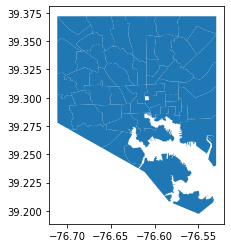

In [ ]:
csa_gdf.plot()

### Approach 2: Converting Pandas into Geopandas

#### Approach 2: Example 1

This approach loads a map using a geometry column

In [ ]:
# The attributes are what we will use.
in_crs = 2248 # The CRS we recieve our data 
out_crs = 4326 # The CRS we would like to have our data represented as
geom = 'geometry' # The column where our spatial information lives.

In [ ]:
# A url to a public Dataset
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQ8xXdUaT17jkdK0MWTJpg3GOy6jMWeaXTlguXNjCSb8Vr_FanSZQRaTU-m811fQz4kyMFK5wcahMNY/pub?gid=886223646&single=true&output=csv'

# Read in the dataframe
tract_df = pd.read_csv(url)

# Convert the geometry column datatype from a string of text into a coordinate datatype
tract_df[geom] = tract_df[geom].apply(lambda x: loads( str(x) ))

# Process the dataframe as a geodataframe with a known CRS and geom column
tract_gdf = GeoDataFrame(tract_df, crs=in_crs, geometry=geom)


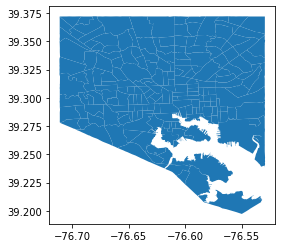

In [ ]:
tract_gdf.plot()

In [ ]:
tract_gdf.head()

TRACTCE10      GEOID10  NAME10                  CSA  Tract             geometry
0     151000  24510151000  1510.0  Dorchester/Ashbu...   1510  POLYGON ((-76.67...
1      80700  24510080700   807.0      Greenmount East    807  POLYGON ((-76.58...
2      80500  24510080500   805.0        Clifton-Berea    805  POLYGON ((-76.58...
3     150500  24510150500  1505.0    Greater Mondawmin   1505  POLYGON ((-76.65...
4     120100  24510120100  1201.0  North Baltimore/...   1201  POLYGON ((-76.60...

#### Approach 2: Example 2: BANKS

In [ ]:
# hide
pd.set_option('max_colwidth', 20)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)

This example is using data constructed at the end of Tutorial 1. 

Be sure to access the menu in the left drawer, hit the 'Files' tab and upload it.

In [ ]:
# Primary Table
# Description: I created a public dataset from a google xlsx sheet 'Bank Addresses and Census Tract' from a workbook of the same name.
# Table: FDIC Baltimore Banks
# Columns: Bank Name, Address(es), Census Tract
left_ds = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTViIZu-hbvhM3L7dIRAG95ISa7TNhUwdzlYxYzc1ygJoaYc3_scaXHe8Rtj5iwNA/pub?gid=1078028768&single=true&output=csv'
left_col = 'Census Tract'

# Alternate Primary Table
# Description: Same workbook, different Sheet: 'Branches per tract' 
# Columns: Census Tract, Number branches per tract
# left_ds = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSHFrRSHva1f82ZQ7Uxwf3A1phqljj1oa2duGlZDM1vLtrm1GI5yHmpVX2ilTfMHQ/pub?gid=1698745725&single=true&output=csv'
# lef_col = 'Number branches per tract'

# Crosswalk Table
# Table: Crosswalk Census Communities
# 'TRACT2010', 'GEOID2010', 'CSA2010'
crosswalk_ds = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE/pub?output=csv'
use_crosswalk = True
crosswalk_left_col = 'TRACT2010'
crosswalk_right_col = 'GEOID2010'

# Secondary Table
# Table: Baltimore Boundaries
# 'TRACTCE10', 'GEOID10', 'CSA', 'NAME10', 'Tract', 'geometry'
right_ds = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQ8xXdUaT17jkdK0MWTJpg3GOy6jMWeaXTlguXNjCSb8Vr_FanSZQRaTU-m811fQz4kyMFK5wcahMNY/pub?gid=886223646&single=true&output=csv'
right_col ='GEOID10'

merge_how = 'geometry'
interactive = True
merge_how = 'outer'

banksPd = mergeDatasets( left_ds=left_ds, left_col=left_col, 
              use_crosswalk=use_crosswalk, crosswalk_ds=crosswalk_ds,
              crosswalk_left_col = crosswalk_left_col, crosswalk_right_col = crosswalk_right_col,
              right_ds=right_ds, right_col=right_col, 
              merge_how=merge_how, interactive = interactive )


 Handling Left Dataset
Left Dataset and Columns are Valid

 Handling Right Dataset
Right Dataset and Columns are Valid

 Checking the merge_how Parameter
merge_how operator is Valid outer

 Checking the Crosswalk Parameter

 Handling Crosswalk Left Dataset Loading

 Handling Crosswalk Right Dataset Loading

 Assessment Completed

 Ensuring Left->Crosswalk compatability
Converting Local Key from float64 to Int

 Ensuring Crosswalk->Right compatability
PERFORMING MERGE LEFT->CROSSWALK
left_on TRACT2010 right_on GEOID2010 how outer

 Local Column Values Not Matched 
[-1321321321321325            400100            401101            401102
            401507            403401            403500            403803
            411306            411406            411408            420100
            420301            420701            420800            430800
            430900            440100            440200            440702
            441101            450300            452000          

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [ ]:
# The attributes are what we will use.
in_crs = 2248 # The CRS we recieve our data 
out_crs = 4326 # The CRS we would like to have our data represented as
geom = 'geometry' # The column where our spatial information lives.

# Description: This was created in the previous tutorial. 
# Description: It can be accessed via accessing a google drive, or by using the upload file feature in the left hand menu. 
# Columns: Bank Information with TRACT, CSA, and GEOMETRY columns.

# To create this dataset I had to commit a full outer join in the previous tutorial. 
# In this way geometries will be included even if there merge does not have a direct match. 
# What this will do is that it means at least one (near) empty record for each community will exist that includes (at minimum) the geographic information and name of a Community.
# That way if no point level information existed in the community, that during the merge the geoboundaries are still carried over.

# If a user wanted to create a heatmap of this data, they would first have to perform an aggregation of their columns onto unique geometry columns.
# It would be the aggregate of of a column that gets colorized on the heatmap. 
# Aggregation operations can easily be performed using a pivot table in XL. 
# I hope to embed support for this functionality in the future. 
# Heatmaps are covered in the next tutorial. 
# Pre-Aggregated information is required to continue on to the next tutorial.
#url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTViIZu-hbvhM3L7dIRAG95ISa7TNhUwdzlYxYzc1ygJoaYc3_scaXHe8Rtj5iwNA/pub?gid=1078028768&single=true&output=csv'

# Read in the dataframe
#df = pd.read_csv(url)

# Convert the geometry column datatype from a string of text into a coordinate datatype
banksPd[geom] = banksPd[geom].apply(lambda x: loads( str(x) ))

# Process the dataframe as a geodataframe with a known CRS and geom column
banksGdf = GeoDataFrame(banksPd, crs=in_crs, geometry=geom)

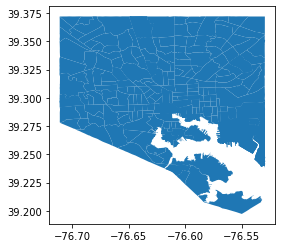

In [ ]:
banksGdf.plot()

In [ ]:
banksGdf.head()

Bank Name          Address(es)  Census Tract  GEOID2010  TRACTCE10      GEOID10   NAME10                  CSA  Tract             geometry
0  Arundel Federal ...  333 E. Patapsco ...      250401.0   2.45e+10     250401  24510250401  2504.01  Brooklyn/Curtis ...   2504  POLYGON ((-76.59...
1                  NaN    3601 S Hanover St      250401.0   2.45e+10     250401  24510250401  2504.01  Brooklyn/Curtis ...   2504  POLYGON ((-76.59...
2  Bank of America,...       20 N Howard St       40100.0   2.45e+10      40100  24510040100   401.00  Downtown/Seton Hill    401  POLYGON ((-76.61...
3                  NaN  100 S Charles St...       40100.0   2.45e+10      40100  24510040100   401.00  Downtown/Seton Hill    401  POLYGON ((-76.61...
4  Branch Banking a...       2 N CHARLES ST       40100.0   2.45e+10      40100  24510040100   401.00  Downtown/Seton Hill    401  POLYGON ((-76.61...

Lets [aggregate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.aggregate.html) by banks by CSA just for fun, huh?



In [ ]:
banksGdf['CSA'].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True).head()

Downtown/Seton Hill                     16
Southwest Baltimore                      8
Oldtown/Middle East                      8
Medfield/Hampden/Woodberry/Remington     8
Fells Point                              7
Name: CSA, dtype: int64

Thats interesting. Lets see if we can map that!

In [ ]:
# Aggregate dataframe by CSA
banksGdf['banksCount'] = 1
banksCount = banksGdf.groupby('CSA').sum(numeric_only=True) 
banksCount = banksCount.reset_index()
banksCount.head()

CSA  Census Tract  GEOID2010  TRACTCE10       GEOID10    NAME10  Tract  banksCount
0  Allendale/Irving...           0.0   0.00e+00    1333309  147061333309  13333.09  13333           6
1  Beechfield/Ten H...      560802.0   4.90e+10    1091306   98041091306  10913.06  10913           4
2        Belair-Edison           0.0   0.00e+00     680806   98040680806   6808.06   6808           4
3  Brooklyn/Curtis ...      500802.0   4.90e+10    1252304  122551252304  12523.04  12523           5
4               Canton       20500.0   4.90e+10      30800   73530030800    308.00    308           3

So now we have the count in a dataframe..

In [ ]:
# A url to a public Dataset
csa_gdf = gpd.read_file("https://opendata.arcgis.com/datasets/b738a8587b6d479a8824d937892701d8_0.geojson");
csa_gdf.head()
csa_gdf.columns

OBJECTID              CSA2010  tpop10  male10  female10  paa17  pwhite17  pasi17  p2more17  ppac17  phisp17  racdiv17  age5_17  age18_17  age24_17  age64_17  age65_17  hhs10  femhhs17  fam17  hhsize10     mhhi17  hh25inc17  hh40inc17  hh60inc17  hh75inc17  hhm7517  hhpov17  hhchpov17  Shape__Area  Shape__Length             geometry
0         1  Allendale/Irving...   16726    7657      9069  90.28      6.53    0.11      1.00    0.00     2.06     20.12     6.61     17.37      9.00     53.29     13.72   6098     71.13  35.20      2.64   39495.63      32.99      17.72      19.91      11.95    17.43    20.70      32.77     6.38e+07       38770.17  POLYGON ((-76.65...
1         2  Beechfield/Ten H...   13391    5985      7406  75.32     18.86    0.42      3.31    0.31     1.78     41.02     7.93     14.58      9.71     55.37     12.42   5076     55.19  26.14      2.40   57572.50      20.42      13.90      18.18      10.87    36.64    10.47      23.92     4.79e+07       37524.95  POLYGON ((-76.69...
2         3        Belair-Edison   17380    7297     10083  85.65     10.03    0.57      1.70    0.81     1.24     27.26     5.42     22.81      8.41     54.45      8.91   6174     77.53  38.27      2.90   39624.48      34.10      16.28      20.07       8.11    21.45    20.27      34.56     4.50e+07       31307.31  POLYGON ((-76.56...
3         4  Brooklyn/Curtis ...   12900    5746      7154  37.96     39.68    2.53      3.61    1.31    14.91     73.93    10.91     16.09      8.25     57.45      7.30   5204     43.39  32.32      2.61   40275.28      31.40      18.32      18.52       9.08    22.68    24.21      46.41     1.76e+08      150987.70  MULTIPOLYGON (((...
4         5               Canton    8326    4094      4232   3.94     85.58    4.38      2.45    0.56     3.09     26.31     5.25      3.12      5.85     75.25     10.53   4310     10.55  11.03      1.86  111891.25       7.41       7.82       9.18       6.43    69.16     3.66       4.02     1.54e+07       23338.61  POLYGON ((-76.57...

Index(['OBJECTID', 'CSA2010', 'tpop10', 'male10', 'female10', 'paa17',
       'pwhite17', 'pasi17', 'p2more17', 'ppac17', 'phisp17', 'racdiv17',
       'age5_17', 'age18_17', 'age24_17', 'age64_17', 'age65_17', 'hhs10',
       'femhhs17', 'fam17', 'hhsize10', 'mhhi17', 'hh25inc17', 'hh40inc17',
       'hh60inc17', 'hh75inc17', 'hhm7517', 'hhpov17', 'hhchpov17',
       'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')

In [ ]:
# merge it to our banks dataset
merged_banks = pd.merge(banksCount, csa_gdf, left_on='CSA', right_on='CSA2010', how='left')
merged_banks.head()

CSA  Census Tract  GEOID2010  TRACTCE10       GEOID10    NAME10  Tract  banksCount  OBJECTID              CSA2010   tpop10  male10  female10  paa17  pwhite17  pasi17  p2more17  ppac17  phisp17  racdiv17  age5_17  age18_17  age24_17  age64_17  age65_17   hhs10  femhhs17  fam17  hhsize10     mhhi17  hh25inc17  hh40inc17  hh60inc17  hh75inc17  hhm7517  hhpov17  hhchpov17  Shape__Area  Shape__Length             geometry
0  Allendale/Irving...           0.0   0.00e+00    1333309  147061333309  13333.09  13333           6       1.0  Allendale/Irving...  16726.0  7657.0    9069.0  90.28      6.53    0.11      1.00    0.00     2.06     20.12     6.61     17.37      9.00     53.29     13.72  6098.0     71.13  35.20      2.64   39495.63      32.99      17.72      19.91      11.95    17.43    20.70      32.77     6.38e+07       38770.17  POLYGON ((-76.65...
1  Beechfield/Ten H...      560802.0   4.90e+10    1091306   98041091306  10913.06  10913           4       2.0  Beechfield/Ten H...  13391.0  5985.0    7406.0  75.32     18.86    0.42      3.31    0.31     1.78     41.02     7.93     14.58      9.71     55.37     12.42  5076.0     55.19  26.14      2.40   57572.50      20.42      13.90      18.18      10.87    36.64    10.47      23.92     4.79e+07       37524.95  POLYGON ((-76.69...
2        Belair-Edison           0.0   0.00e+00     680806   98040680806   6808.06   6808           4       3.0        Belair-Edison  17380.0  7297.0   10083.0  85.65     10.03    0.57      1.70    0.81     1.24     27.26     5.42     22.81      8.41     54.45      8.91  6174.0     77.53  38.27      2.90   39624.48      34.10      16.28      20.07       8.11    21.45    20.27      34.56     4.50e+07       31307.31  POLYGON ((-76.56...
3  Brooklyn/Curtis ...      500802.0   4.90e+10    1252304  122551252304  12523.04  12523           5       4.0  Brooklyn/Curtis ...  12900.0  5746.0    7154.0  37.96     39.68    2.53      3.61    1.31    14.91     73.93    10.91     16.09      8.25     57.45      7.30  5204.0     43.39  32.32      2.61   40275.28      31.40      18.32      18.52       9.08    22.68    24.21      46.41     1.76e+08      150987.70  MULTIPOLYGON (((...
4               Canton       20500.0   4.90e+10      30800   73530030800    308.00    308           3       5.0               Canton   8326.0  4094.0    4232.0   3.94     85.58    4.38      2.45    0.56     3.09     26.31     5.25      3.12      5.85     75.25     10.53  4310.0     10.55  11.03      1.86  111891.25       7.41       7.82       9.18       6.43    69.16     3.66       4.02     1.54e+07       23338.61  POLYGON ((-76.57...

In [ ]:
# Lets check what datatype our geometry column is before we try to convert it!
merged_banks.geometry.dtype

In [ ]:
# Process the dataframe as a geodataframe with a known CRS and geom column
# Since the geometry column is already being interpreted as a geopandas dtype,
# we should readily be able to convert the dataframe without fuss.
banksCountgdf = GeoDataFrame(merged_banks, crs=2248, geometry='geometry')

In [ ]:
# If you'd like, drop duplicate columns like so.
# merged_df = merged_df.drop('CSA', axis=1)

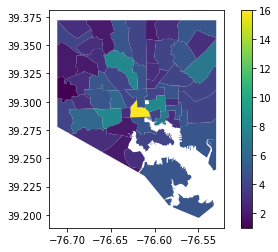

In [ ]:
# In order for this choropleth to work, the total number of banks in each csa must be tallied.
# This can be done programmatically, but i havent added the code. 
# The column needs to be changed from CSA to whatever this new tallied column is named.
banksCountgdf.plot( column='banksCount', legend=True)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


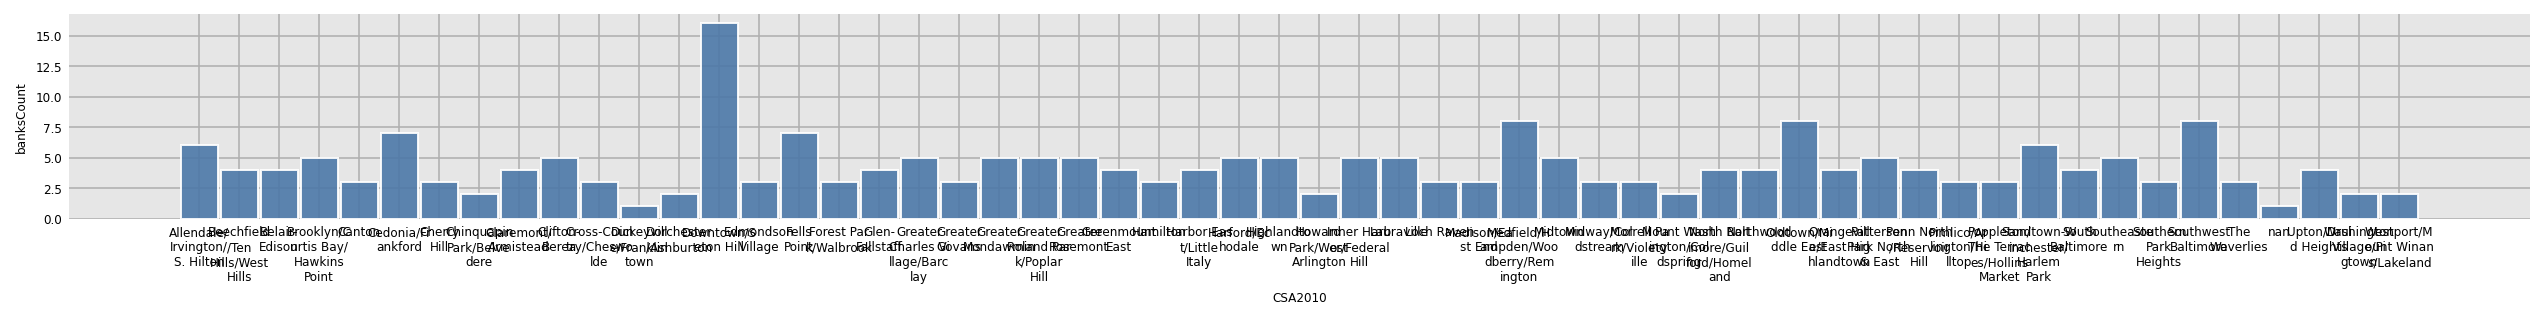

In [ ]:
dxp.bar(x='CSA2010', y='banksCount', data=banksCountgdf)

Go ahead and update the form and run the cell to explore the data visually!

In [ ]:
tempBanksNoGeom = banksCountgdf.drop('geometry', axis=1)

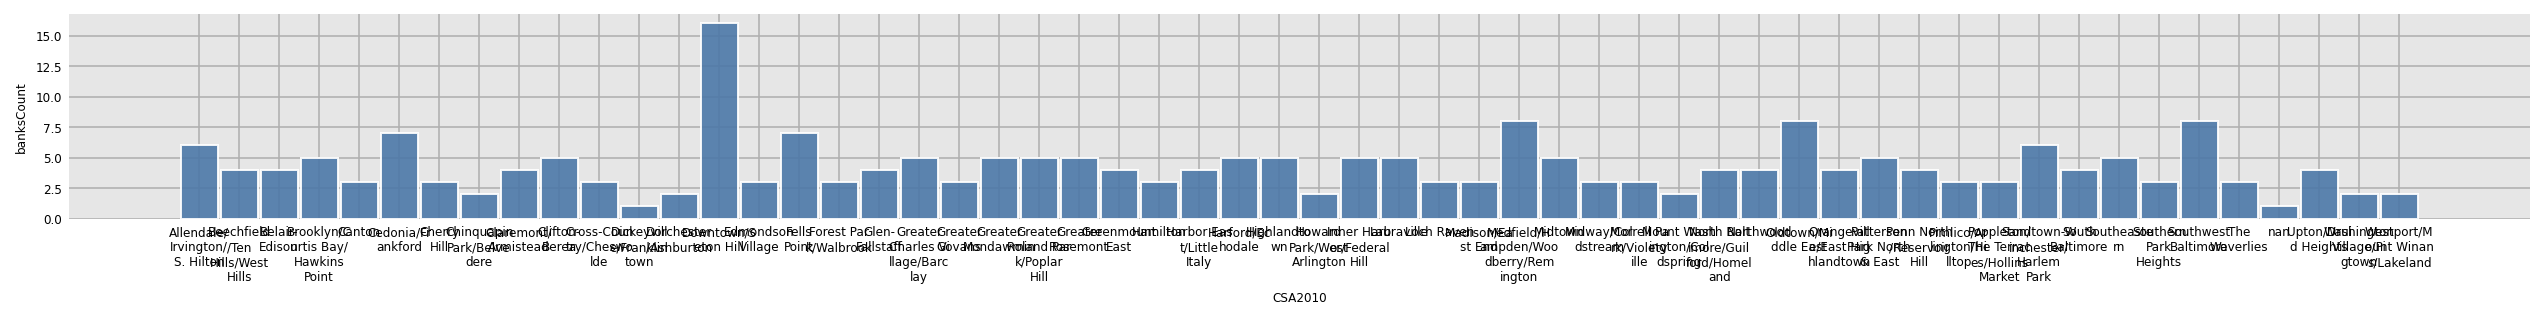

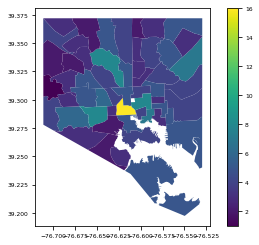

In [ ]:
#@title Form fields to view spatial data
#@markdown Forms support many types of fields.

legendOn = "True"  #@param ['True', 'False']
displayCol = "banksCount" #@param ["banksCount", 'tpop10', 'male10', 'female10', 'paa17', 'pwhite17', 'pasi17', 'p2more17', 'ppac17', 'phisp17', 'racdiv17', 'age5_17', 'age18_17', 'age24_17', 'age64_17', 'age65_17', 'hhs10', 'femhhs17', 'fam17', 'hhsize10', 'mhhi17', 'hh25inc17', 'hh40inc17', 'hh60inc17', 'hh75inc17', 'hhm7517', 'hhpov17', 'hhchpov17"] {allow-input: true}
#@markdown ---

banksCountgdf.plot( column=displayCol, legend=legendOn)
dxp.bar(x='CSA2010', 
        y=displayCol, 
        data=banksCountgdf)

In [ ]:
banksCountgdf.dropna().CSA2010.values

array(['Allendale/Irvington/S. Hilton', 'Beechfield/Ten Hills/West Hills',
       'Belair-Edison', 'Brooklyn/Curtis Bay/Hawkins Point', 'Canton',
       'Cedonia/Frankford', 'Cherry Hill', 'Chinquapin Park/Belvedere',
       'Claremont/Armistead', 'Clifton-Berea', 'Cross-Country/Cheswolde',
       'Dickeyville/Franklintown', 'Dorchester/Ashburton',
       'Downtown/Seton Hill', 'Edmondson Village', 'Fells Point',
       'Forest Park/Walbrook', 'Glen-Fallstaff',
       'Greater Charles Village/Barclay', 'Greater Govans',
       'Greater Mondawmin', 'Greater Roland Park/Poplar Hill',
       'Greater Rosemont', 'Greenmount East', 'Hamilton',
       'Harbor East/Little Italy', 'Harford/Echodale', 'Highlandtown',
       'Howard Park/West Arlington', 'Inner Harbor/Federal Hill',
       'Lauraville', 'Loch Raven', 'Madison/East End',
       'Medfield/Hampden/Woodberry/Remington', 'Midtown',
       'Midway/Coldstream', 'Morrell Park/Violetville',
       'Mount Washington/Coldspring', 'North Ba

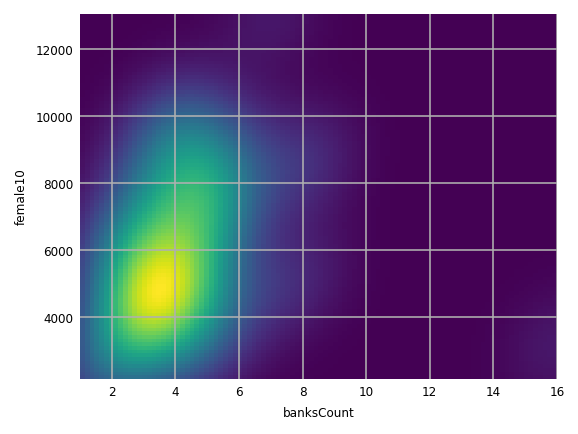

In [ ]:
#@title Now lets compare some indicators
#@markdown Forms support many types of fields.

legendOn = "True"  #@param ['True', 'False']
displayColx = "banksCount" #@param ["banksCount", 'tpop10', 'male10', 'female10', 'paa17', 'pwhite17', 'pasi17', 'p2more17', 'ppac17', 'phisp17', 'racdiv17', 'age5_17', 'age18_17', 'age24_17', 'age64_17', 'age65_17', 'hhs10', 'femhhs17', 'fam17', 'hhsize10', 'mhhi17', 'hh25inc17', 'hh40inc17', 'hh60inc17', 'hh75inc17', 'hhm7517', 'hhpov17', 'hhchpov17"] {allow-input: true}
displayColy = "female10" #@param ["banksCount", 'tpop10', 'male10', 'female10', 'paa17', 'pwhite17', 'pasi17', 'p2more17', 'ppac17', 'phisp17', 'racdiv17', 'age5_17', 'age18_17', 'age24_17', 'age64_17', 'age65_17', 'hhs10', 'femhhs17', 'fam17', 'hhsize10', 'mhhi17', 'hh25inc17', 'hh40inc17', 'hh60inc17', 'hh75inc17', 'hhm7517', 'hhpov17', 'hhchpov17"] {allow-input: true}
# displayColm = "Westport/Mount Winans/Lakeland" #@param ['Allendale/Irvington/S. Hilton', 'Beechfield/Ten Hills/West Hills', 'Belair-Edison', 'Brooklyn/Curtis Bay/Hawkins Point', 'Canton', 'Cedonia/Frankford', 'Cherry Hill', 'Chinquapin Park/Belvedere', 'Claremont/Armistead', 'Clifton-Berea', 'Cross-Country/Cheswolde', 'Dickeyville/Franklintown', 'Dorchester/Ashburton', 'Downtown/Seton Hill', 'Edmondson Village', 'Fells Point', 'Forest Park/Walbrook', 'Glen-Fallstaff', 'Greater Charles Village/Barclay', 'Greater Govans', 'Greater Mondawmin', 'Greater Roland Park/Poplar Hill', 'Greater Rosemont', 'Greenmount East', 'Hamilton', 'Harbor East/Little Italy', 'Harford/Echodale', 'Highlandtown', 'Howard Park/West Arlington', 'Inner Harbor/Federal Hill', 'Lauraville', 'Loch Raven', 'Madison/East End', 'Medfield/Hampden/Woodberry/Remington', 'Midtown', 'Midway/Coldstream', 'Morrell Park/Violetville', 'Mount Washington/Coldspring', 'North Baltimore/Guilford/Homeland', 'Northwood', 'Oldtown/Middle East', 'Orangeville/East Highlandtown', 'Patterson Park North & East', 'Penn North/Reservoir Hill', 'Pimlico/Arlington/Hilltop', 'Poppleton/The Terraces/Hollins Market', 'Sandtown-Winchester/Harlem Park', 'South Baltimore', 'Southeastern', 'Southern Park Heights', 'Southwest Baltimore', 'The Waverlies', 'Upton/Druid Heights', 'Washington Village/Pigtown', 'Westport/Mount Winans/Lakeland'] {allow-input: true}
#@markdown ---

# print('Comparing', displayColm, "'s Indicators ", displayColx, " and " , displayColy )
dxp.kde(x=displayColx, y=displayColy, data= banksCountgdf.dropna() )

In [ ]:
# dxp.kde(x=displayColx, y=displayColy, data= banksCountgdf[ banksCountgdf.CSA2010 != displayColm ].dropna() )

#### Approach 3: Method 1: Convert Column(s) to Coordinate

Later in this tutorial we will show how you may find geometric bounds that coorespond with a points location ( points in polygons ). This can be a useful trick when we we want to create a heatmap of point data with specified boundaries.

If a user wanted to create a heatmap of this data...

they would first have to perform an aggregation of their columns onto unique geometry columns 

Possible Path: (points in polygons -> crosswalk -> merge GeoJson).

It would be the aggregate of of a column that gets colorized on the heatmap. 

Aggregation operations can easily be performed using a pivot table in XL. 

I hope to embed support for this functionality in the future. 

Heatmaps are covered in the next tutorial. 

Pre-Aggregated information is required to continue onto the next tutorial.

Approach 3: Method 1:  Example 1:

This is the generic example but it wont work since no URL is given.

In [ ]:
# More Information: https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html#from-longitudes-and-latitudes

# If your data has coordinates in two columns run this cell
# It will create a geometry column from the two.
# A public dataset is not provided for this example and will not run.

# Load DF HERE. Accidently deleted the link. Need to refind. 
# Just rely on example 2 for now. 
exe_df = ''

exe_df['x'] = pd.to_numeric(exe_df['x'], errors='coerce')
exe_df['y'] = pd.to_numeric(exe_df['y'], errors='coerce')
# exe_df = exe_df.replace(np.nan, 0, regex=True)

# An example of loading in an internal BNIA file
crs = {'init' :'epsg:2248'} 
geometry=[Point(xy) for xy in zip(exe_df.x, exe_df.y)]
exe_gdf = gpd.GeoDataFrame( exe_df.drop(['x', 'y'], axis=1), crs=in_crs, geometry=geometry)

Approach 3: Method 1:  Example 2: FOOD BANK PANTRIES

In [ ]:
# Alternate Primary Table
# Table: Food Bank And Pantry Sites, 
# XLSX Sheet: Baltimore City Pantries Tracts
# Columns: X	Y	OBJECTID	Name	Address	City_1	State	Zip	# in Zip	FIPS
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT3lG0n542sIGE2O-C8fiXx-qUZG2WDO6ezRGcNsS4z8MM30XocVZ90P1UQOIXO2w/pub?gid=1152681223&single=true&output=csv'

# Read in the dataframe
food_df = pd.read_csv(url)

In [ ]:
food_df['X'] = pd.to_numeric(food_df['X'], errors='coerce')
food_df['Y'] = pd.to_numeric(food_df['Y'], errors='coerce')
# df = df.replace(np.nan, 0, regex=True)

# An example of loading in an internal BNIA file
crs = {'init' :'epsg:2248'} 
geometry=[Point(xy) for xy in zip(food_df['X'], food_df['Y'])]
food_gdf = gpd.GeoDataFrame( food_df.drop(['X', 'Y'], axis=1), crs=in_crs, geometry=geometry)

In [ ]:
food_gdf.head()

OBJECTID                 Name              Address           City_1 State    Zip  # in Zip  FIPS             geometry
0         1  Victory Forest -...  10000 Brunswick ...    Silver Spring    MD  20817       NaN   NaN  POINT (-77.05673...
1         2  Glassmanor Eleme...    1011 Marcy Avenue        Oxon Hill    MD  20745       NaN   NaN  POINT (-76.99036...
2         3       Apple Blossoms  1013 Cresthaven ...    Silver Spring    MD  20903       NaN   NaN  POINT (-76.99155...
3         4  Lakeview Apartme...  10250 West Lake Dr.         Bethesda    MD  20817       NaN   NaN  POINT (-77.14929...
4         5      Central Gardens       103 Cindy Lane  Capitol Heights    MD              NaN   NaN  POINT (-76.88974...

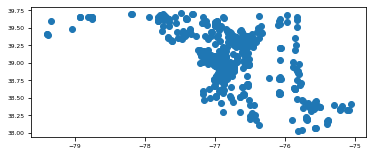

In [ ]:
food_gdf.plot()

As you can see we have a lot of points. 
Lets see if there is any better way to visualize this.

In [ ]:
import folium
from folium import plugins
def map_points(df, lat_col='latitude', lon_col='longitude', zoom_start=11, plot_points=False, pt_radius=15, draw_heatmap=False, heat_map_weights_col=None, heat_map_weights_normalize=True, heat_map_radius=15):
    """Creates a map given a dataframe of points. Can also produce a heatmap overlay

    Arg:
        df: dataframe containing points to maps
        lat_col: Column containing latitude (string)
        lon_col: Column containing longitude (string)
        zoom_start: Integer representing the initial zoom of the map
        plot_points: Add points to map (boolean)
        pt_radius: Size of each point
        draw_heatmap: Add heatmap to map (boolean)
        heat_map_weights_col: Column containing heatmap weights
        heat_map_weights_normalize: Normalize heatmap weights (boolean)
        heat_map_radius: Size of heatmap point

    Returns:
        folium map object
    """

    ## center map in the middle of points center in
    middle_lat = df[lat_col].median()
    middle_lon = df[lon_col].median()

    curr_map = folium.Map(location=[middle_lat, middle_lon],
                          zoom_start=zoom_start)

    # add points to map
    if plot_points:
        for _, row in df.iterrows():
            folium.CircleMarker([row[lat_col], row[lon_col]],
                                radius=pt_radius,
                                popup=row['Name'],
                                fill_color="#3db7e4", # divvy color
                               ).add_to(curr_map)

    # add heatmap
    if draw_heatmap:
        # convert to (n, 2) or (n, 3) matrix format
        if heat_map_weights_col is None:
            cols_to_pull = [lat_col, lon_col]
        else:
            # if we have to normalize
            if heat_map_weights_normalize:
                df[heat_map_weights_col] = \
                    df[heat_map_weights_col] / df[heat_map_weights_col].sum()

            cols_to_pull = [lat_col, lon_col, heat_map_weights_col]

        stations = df[cols_to_pull].to_numpy()
        curr_map.add_children(plugins.HeatMap(stations, radius=heat_map_radius))

    return curr_map

In [ ]:
map_points(food_df, lat_col='Y', lon_col='X', zoom_start=11, plot_points=True, pt_radius=15, draw_heatmap=True, heat_map_weights_col=None, heat_map_weights_normalize=True, heat_map_radius=15)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


#### Approach 3: Method 2: Geocoding Addresses to Coordinates

This function takes a while. The less columns/data/records the faster it execues.

In [ ]:
# More information vist: https://geopy.readthedocs.io/en/stable/#module-geopy.geocoders

# In this example we retrieve and map a dataset with no lat/lng but containing an address

# The url listed below is public.
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTMgdqWykZeIsMwCFllPuG1cd4gGDB6BUqaAOM0Lx9VGdCo2JJy9v_CR8ZaEDWO3Q/pub?gid=290715815&single=true&output=csv'
df = pd.read_csv(url)

# In this example our data is stored in the 'STREET' attribute
addrCol = 'STREET'
geometry = []
geolocator = Nominatim(user_agent="specify_your_app_name_here")

for index, row in df.iterrows():
  # We will try and return an address for each Street Name
  try: 
      # retrieve the geocoded information of our street address
      geol = geolocator.geocode(row[addrCol], timeout=None)
      
      print('Geocoding: ', location.address) 
      # print(location.raw)
      
      # create a mappable coordinate point from the response object's lat/lang values.
      pnt = Point(geol.longitude, geol.latitude)
      
      # Append this value to the list of geometries
      geometry.append(pnt)
      
  except: 
      # If no street name was found decide what to do here.
      # df.loc[index]['geom'] = Point(0,0) # Alternate method
      geometry.append(Point(0,0))
      
# Finally, we stuff the geometry data we created back into the dataframe
df['geometry'] = geometry

# Convert the dataframe into a geodataframe and map it!
gdf = gpd.GeoDataFrame( df, geometry=geometry)

In [ ]:
food_gdf2.head()

OBJECTID                 Name              Address           City_1 State    Zip  # in Zip  FIPS          fulladdress             geometry
0         1  Victory Forest -...  10000 Brunswick ...    Silver Spring    MD  20817       NaN   NaN  10000 Brunswick ...  POINT (0.00000 0...
1         2  Glassmanor Eleme...    1011 Marcy Avenue        Oxon Hill    MD  20745       NaN   NaN  1011 Marcy Avenu...  POINT (0.00000 0...
2         3       Apple Blossoms  1013 Cresthaven ...    Silver Spring    MD  20903       NaN   NaN  1013 Cresthaven ...  POINT (0.00000 0...
3         4  Lakeview Apartme...  10250 West Lake Dr.         Bethesda    MD  20817       NaN   NaN  10250 West Lake ...  POINT (0.00000 0...
4         5      Central Gardens       103 Cindy Lane  Capitol Heights    MD              NaN   NaN  103 Cindy Lane C...  POINT (0.00000 0...

### Approach 4: Connecting to a PostGIS database

In the following example pulls point geodata from a Postgres database.

We will pull the postgres point data in two manners. 
- SQL query where an SQL query uses ST_Transform(the_geom,4326) to transform the_geom's CRS from a DATABASE Binary encoding into standard Lat Long's
- Using a plan SQL query and performing the conversion using gpd.io.sql.read_postgis() to pull the data in as 2248 and convert the CRS using .to_crs(epsg=4326)
- These examples will not work in colabs as their is no local database to connect to and has been commented out for that reason

In [ ]:
# This Notebook can be downloaded to connect to a database
'''
conn = psycopg2.connect(host='', dbname='', user='', password='', port='')

# DB Import Method One
sql1 = 'SELECT the_geom, gid, geogcode, ooi, address, addrtyp, city, block, lot, desclu, existing FROM housing.mdprop_2017v2 limit 100;'
pointData = gpd.io.sql.read_postgis(sql1, conn, geom_col='the_geom', crs=2248)
pointData = pointData.to_crs(epsg=4326)

# DB Import Method Two
sql2 = 'SELECT ST_Transform(the_geom,4326) as the_geom, ooi, desclu, address FROM housing.mdprop_2017v2;'
pointData = gpd.GeoDataFrame.from_postgis(sql2, conn, geom_col='the_geom', crs=4326)
pointData.head()
pointData.plot()
'''

"\nconn = psycopg2.connect(host='', dbname='', user='', password='', port='')\n\n# DB Import Method One\nsql1 = 'SELECT the_geom, gid, geogcode, ooi, address, addrtyp, city, block, lot, desclu, existing FROM housing.mdprop_2017v2 limit 100;'\npointData = gpd.io.sql.read_postgis(sql1, conn, geom_col='the_geom', crs=2248)\npointData = pointData.to_crs(epsg=4326)\n\n# DB Import Method Two\nsql2 = 'SELECT ST_Transform(the_geom,4326) as the_geom, ooi, desclu, address FROM housing.mdprop_2017v2;'\npointData = gpd.GeoDataFrame.from_postgis(sql2, conn, geom_col='the_geom', crs=4326)\npointData.head()\npointData.plot()\n"

## Basics Operations

### Inspection

In [ ]:
def geomSummary(gdf): return type(gdf), gdf.crs, gdf.columns;
# for p in df['Tract'].sort_values(): print(p)
geomSummary(csa_gdf)

(geopandas.geodataframe.GeoDataFrame, <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich, Index(['OBJECTID', 'CSA2010', 'tpop10', 'male10', 'female10', 'paa17',
        'pwhite17', 'pasi17', 'p2more17', 'ppac17', 'phisp17', 'racdiv17',
        'age5_17', 'age18_17', 'age24_17', 'age64_17', 'age65_17', 'hhs10',
        'femhhs17', 'fam17', 'hhsize10', 'mhhi17', 'hh25inc17', 'hh40inc17',
        'hh60inc17', 'hh75inc17', 'hhm7517', 'hhpov17', 'hhchpov17',
        'Shape__Area', 'Shape__Length', 'geometry'],
       dtype='object'))

### Converting CRS

In [ ]:
# Convert the CRS of the dataset into one you desire
# The gdf must be loaded with a known crs in order for the to_crs conversion to work
# We use this often to converting BNIAs custom CRS to the common type 
out_crs = 4326
csa_gdf = gdf.to_crs(epsg=out_crs)

### Saving

In [ ]:
# Here is code to comit a simple save
filename = 'TEST_FILE_NAME'
csa_gdf.to_file(f"{filename}.geojson", driver='GeoJSON')

In [ ]:
# Here is code to save this new projection as a geojson file and read it back in
csa_gdf = csa_gdf.to_crs(epsg=2248) #just making sure
csa_gdf.to_file(filename+'.shp', driver='ESRI Shapefile')
csa_gdf = gpd.read_file(filename+'.shp')

### Geometric Manipulations

Draw Tool

In [ ]:
from folium.plugins import Draw
# Draw tool. Create and export your own boundaries
m = folium.Map()
draw = Draw()
draw.add_to(m)
m = folium.Map(location=[-27.23, -48.36], zoom_start=12)
draw = Draw(export=True)
draw.add_to(m)
# m.save(os.path.join('results', 'Draw1.html'))
m

Boundary

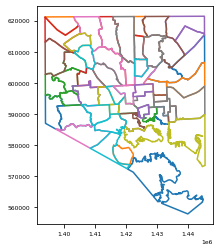

In [ ]:
newcsa = csa_gdf.copy()
newcsa['geometry'] = csa_gdf.boundary
newcsa.plot(column='CSA2010' )

envelope

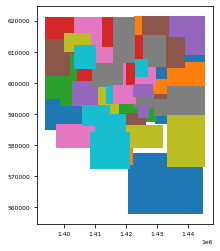

In [ ]:
newcsa = csa_gdf.copy()
newcsa['geometry'] = csa_gdf.envelope
newcsa.plot(column='CSA2010' )

convex_hull

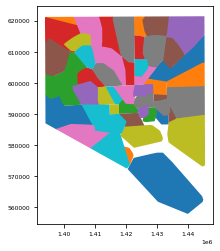

In [ ]:
newcsa = csa_gdf.copy()
newcsa['geometry'] = csa_gdf.convex_hull
newcsa.plot(column='CSA2010' )
# , cmap='OrRd', scheme='quantiles'
# newcsa.boundary.plot(  )

simplify

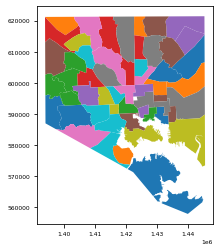

In [ ]:
newcsa = csa_gdf.copy()
newcsa['geometry'] = csa_gdf.simplify(30)
newcsa.plot(column='CSA2010' )

buffer

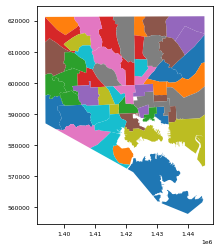

In [ ]:
newcsa = csa_gdf.copy()
newcsa['geometry'] = csa_gdf.buffer(0.01)
newcsa.plot(column='CSA2010' )

rotate

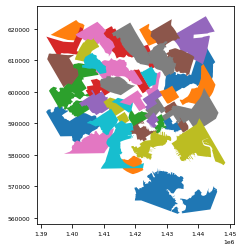

In [ ]:
newcsa = csa_gdf.copy()
newcsa['geometry'] = csa_gdf.rotate(30)
newcsa.plot(column='CSA2010' )

scale

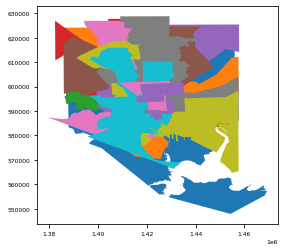

In [ ]:
newcsa = csa_gdf.copy()
newcsa['geometry'] = csa_gdf.scale(3, 2)
newcsa.plot(column='CSA2010' )

skew

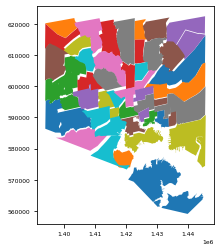

In [ ]:
newcsa = csa_gdf.copy()
newcsa['geometry'] = csa_gdf.skew(1, 10)
newcsa.plot(column='CSA2010' )

# Advanced

**Operations:** 

- Reading in data (points/ geoms)
-- Convert lat/lng columns to point coordinates
-- Geocoding address to coordinates
-- Changing coordinate reference systems
-- Connecting to PostGisDB's
- Basic Operations
- Saving shape data
- Get Polygon Centroids
- Working with Points and Polygons
-- Map Points and Polygons
-- Get Points in Polygons

**Input(s):** 
- Dataset (points/ bounds) url
- Points/ bounds geometry column(s)
- Points/ bounds crs's
- Points/ bounds mapping color(s)
- New filename

**Output:** File

## Create Geospatial Functions

This function will handle common geo spatial exploratory methods. It covers everything discussed in the basic operations and more!

In [ ]:
#
# Work With Geometry Data
# Description: geomSummary, getPointsInPolygons, mapPointsInPolygons, getCentroids
# 
#
def workWithGeometryData(method=False, df=False, polys=False, ptsCoordCol=False, polygonsCoordCol=False, pntsClr='red', polysClr='white'):
  print('TheStartOfSomethingNew')
 
  def geomSummary(df): return type(gdf), gdf.crs, gdf.columns;
  
  def getCentroid(df, col): return df[col].representative_point()
  #final['centroid'] = final['geometry'].centroid

  # To 'import' a script you wrote, map its filepath into the sys
  def getPointsInPolygons(pts, polygons, ptsCoordCol, polygonsCoordCol): 
      # We're going to keep a list of how many points we find.
      pts_in_polys = []

      # Loop over polygons with index i.
      for i, poly in polygons.iterrows():
          print('Searching for point within Geom:', poly )
          # Keep a list of points in this poly
          pts_in_this_poly = []

          # Now loop over all points with index j.
          for j, pt in pts.iterrows():
              if poly[polygonsCoordCol].contains(pt[ptsCoordCol]):
                  # Then it's a hit! Add it to the list,
                  # and drop it so we have less hunting.
                  pts_in_this_poly.append(pt[ptsCoordCol])
                  pts = pts.drop([j])

          # We could do all sorts, like grab a property of the
          # points, but let's just append the number of them.
          pts_in_polys.append(len(pts_in_this_poly))
          print('Found this many points within the Geom:', len(pts_in_this_poly) )

      # Add the number of points for each poly to the dataframe.
      polygons['number of points'] = gpd.GeoSeries(pts_in_polys)
      return polygons
  
  def mapPointsandPolygons(pnts, polys, pntsCl, polysClr):
    print('mapPointsandPolygons');
    # We restrict to South America.
    ax = polys.plot( color=polysClr, edgecolor='black')

    # We can now plot our ``GeoDataFrame``.
    pnts.plot(ax=ax, color=pntsClr)

    return plt.show()
  
  
  if method=='summary': return geomSummary(df);
  if method=='pinp': return getPointsInPolygons(df, polys, ptsCoordCol, polygonsCoordCol);
  if method=='pandp': return mapPointsandPolygons(df, polys, pntsClr, polysClr);
  if method=='centroid': return getCentroid(df, col);

Processing Geometry is tedius enough to merit its own handler

In [ ]:
def readInGeometryData(url=False, porg=False, geom=False, lat=False, lng=False, revgeocode=False,  save=False, in_crs=4326, out_crs=False):

  def reverseGeoCode(df, lat ):
    # STREET	CITY	STATE ZIP NAME
    # , format_string="%s, BALTIMORE MD"
    geometry = []
    geolocator = Nominatim(user_agent="specify_your_app_name_here")
    for index, row in df.iterrows():
      try: 
          geol = geolocator.geocode(row[lat], timeout=None)
          pnt = Point(geol.longitude, geol.latitude)
          geometry.append(pnt)
      except: 
          geometry.append(Point(-76, 39) )
          print(row[lat]);
    return geometry
    
    
    
  def readFile(url, geom, lat, lng, revgeocode, in_crs, out_crs):
    df = False
    ext = url[-3:]
    
    #XLS
    # b16 = pd.read_excel('Jones.BirthsbyCensus2016.XLS', sheetname='Births')

    # The file extension is used to determine the appropriate import method.
    if ext in ['son', 'kml', 'shp']: gdf = gpd.read_file(url)  

    if ext == 'csv':
      df = pd.read_csv(url)
      print( df.columns)
      # Read using Geom, Lat, Lat/Lng, revGeoCode 
      if revgeocode=='y': df['geometry'] = reverseGeoCode(df, lat)
      elif geom: df['geometry'] = df[geom].apply(lambda x: loads( str(x) )) 
      elif lat==lng: df['geometry'] = df[lat].apply(lambda x: loads( str(x) ))
      elif lat!=lng: df['geometry'] = gpd.points_from_xy(df[lng], df[lat]);
      
      gdf = GeoDataFrame(df, crs=in_crs, geometry='geometry') #crs=2248
      if not out_crs == in_crs: gdf = gdf.to_crs(epsg=out_crs)
    return gdf
  
  
  def getGeoParams(url, porg, geom, lat, lng, revgeocode, save, in_crs, out_crs):
    addr=False
    
    if not url: url = input("Please enter the location of your dataset: " ) 
    # if url[-3:] == 'csv' : 
    #   df = pd.read_csv(url,index_col=0,nrows=1)
    #   print(df.columns)

    # Geometries inside
    if geom and not (lat and lng): porg = 'g'
    # Point data inside
    elif not geom and lat or lng: 
      porg = 'p';
      if not lat: lat = lng
      if not lng: lng = lat  
        
    # If the P/G could not be infered...
    if not (porg in ['p', 'g']): 
      if not revgeocode in ['y', 'n']: revgeocode = input("Do your records need reverse geocoding: (Enter: y/n') " )
      if revgeocode == 'y': porg = 'p'; lng = lat = input("Please enter the column name where the address is stored: " );
      elif revgeocode == 'n': porg = input("""Do the records in this dataset use (P)oints or (g)eometric polygons?: (Enter: 'p' or 'g') """ );
      else: return getGeoParams(url, porg, geom, lat, lng, revgeocode, save, in_crs, out_crs);
        
      if porg=='p':
          if not lat: lat = input("Please enter the column name where the latitude coordinate is stored: " );
          if not lng: lng = input("Please enter the column name where the longitude cooridnate is stored: (Could be same as the lat) " );
      elif porg=='g': 
        if not geom: geom = input("Please enter column name where the geometry data is stored: (*optional, skip if unkown)" );
      else: return getGeoParams(url, porg, geom, lat, lng, revgeocode, save, in_crs, out_crs)
    
    if not out_crs: out_crs=in_crs
      
    return url, porg, geom, lat, lng, revgeocode, save, in_crs, out_crs
  
  # This function uses all the other functions
  def main(url, porg, geom, lat, lng, revgeocode, save, in_crs, out_crs):
    
    # Check for missing values. retrieve them
    if (not (url and porg) ) or (
        not (porg == 'p' or porg == 'g') ) or (
        porg == 'g' and not geom) or (
        porg == 'p' and (not (lat and lng) ) ): 
      return readInGeometryData( *getGeoParams(url, porg, geom, lat, lng, revgeocode, save, in_crs, out_crs) );

    print(f"RECIEVED url: {url}, \n porg: {porg}, \n geom: {geom}, \n lat: {lat}, \n lng: {lng}, \n revgeocode: {revgeocode}, \n in_crs: {in_crs}, \n out_crs: {out_crs}")
    
    # Quit if the Columns dont exist -> CSV Only
    # status = checkColumns(url, geom, lat, lng)
    # if status == False: print('A specified column does not exist'); return False;

    # Perform operation
    gdf = readFile(url, geom, lat, lng, revgeocode, in_crs, out_crs)
    
    # Tidy up
    
    # Save
    # if save: saveGeoData(gdf, url, fileName, driver='esri')
    
    return gdf
  
  return main(url, porg, geom, lat, lng, revgeocode, save, in_crs, out_crs)

## Example: Using the advanced Functions

### Simple  Examples

RECIEVED url: https://docs.google.com/spreadsheets/d/e/2PACX-1vQ8xXdUaT17jkdK0MWTJpg3GOy6jMWeaXTlguXNjCSb8Vr_FanSZQRaTU-m811fQz4kyMFK5wcahMNY/pub?gid=886223646&single=true&output=csv, 
 porg: g, 
 geom: geometry, 
 lat: False, 
 lng: False, 
 revgeocode: False, 
 in_crs: 2248, 
 out_crs: 4326
Index(['TRACTCE10', 'GEOID10', 'NAME10', 'CSA', 'Tract', 'geometry'], dtype='object')
TheStartOfSomethingNew


(geopandas.geodataframe.GeoDataFrame, <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich, Index(['OBJECTID', 'CSA2010', 'tpop10', 'male10', 'female10', 'paa17',
        'pwhite17', 'pasi17', 'p2more17', 'ppac17', 'phisp17', 'racdiv17',
        'age5_17', 'age18_17', 'age24_17', 'age64_17', 'age65_17', 'hhs10',
        'femhhs17', 'fam17', 'hhsize10', 'mhhi17', 'hh25inc17', 'hh40inc17',
        'hh60inc17', 'hh75inc17', 'hhm7517', 'hhpov17', 'hhchpov17',
        'Shape__Area', 'Shape__Length', 'geometry'],
       dtype='object'))

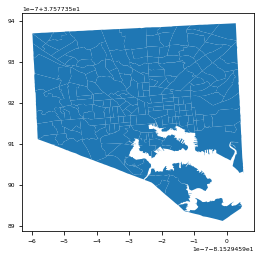

In [ ]:
# Example 0: Loading describing and plotting a simple shapefile.
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQ8xXdUaT17jkdK0MWTJpg3GOy6jMWeaXTlguXNjCSb8Vr_FanSZQRaTU-m811fQz4kyMFK5wcahMNY/pub?gid=886223646&single=true&output=csv'
geom = readInGeometryData(url=url, geom='geometry', in_crs=2248, out_crs=4326)
workWithGeometryData('summary', geom) 
geom.plot()

In [ ]:
# Example Points 1: Loading Tax data from addresses. Get sent to coordinates.
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTMgdqWykZeIsMwCFllPuG1cd4gGDB6BUqaAOM0Lx9VGdCo2JJy9v_CR8ZaEDWO3Q/pub?gid=290715815&single=true&output=csv'
points = readInGeometryData(url=url, revgeocode='y', lat='ADDRESS')
workWithGeometryData('summary', points) 

PO BOX 67008, BALTIMORE MD
PO BOX 4496, BALTIMORE MD
120 W NORTH AVENUE STE 307, BALTIMORE MD
PO BOX 27039, BALTIMORE MD
1731 E CHASE ST, BALTIMORE MD
100 LIGHT STREET 12TH FLOOR, BALTIMORE MD
1138 HOLLINS STREET 2ND FLOOR, BALTIMORE MD


RECIEVED url: https://docs.google.com/spreadsheets/d/e/2PACX-1vT3lG0n542sIGE2O-C8fiXx-qUZG2WDO6ezRGcNsS4z8MM30XocVZ90P1UQOIXO2w/pub?gid=1152681223&single=true&output=csv, 
 porg: p, 
 geom: False, 
 lat: Y, 
 lng: X, 
 revgeocode: False, 
 in_crs: {'init': 'epsg:2248'}, 
 out_crs: {'init': 'epsg:2248'}
Index(['X', 'Y', 'OBJECTID', 'Name', 'Address', 'City_1', 'State', 'Zip',
       '# in Zip', 'FIPS'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


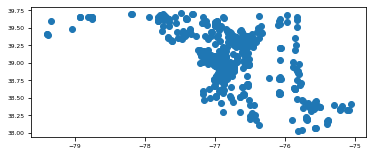

In [ ]:
# Example Points 2: Loading Food Pantries as Points using this new tool
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT3lG0n542sIGE2O-C8fiXx-qUZG2WDO6ezRGcNsS4z8MM30XocVZ90P1UQOIXO2w/pub?gid=1152681223&single=true&output=csv'
crs = {'init' :'epsg:2248'} 
points = readInGeometryData(url=url, porg='p', geom=False, lat='Y', lng='X', revgeocode=False,  save=False, in_crs=crs, out_crs=crs)
points.plot()

In [ ]:
points

X      Y  OBJECTID                 Name              Address           City_1 State    Zip  # in Zip  FIPS             geometry
0   -77.06  39.02         1  Victory Forest -...  10000 Brunswick ...    Silver Spring    MD  20817       NaN   NaN  POINT (-77.05673...
1   -76.99  38.82         2  Glassmanor Eleme...    1011 Marcy Avenue        Oxon Hill    MD  20745       NaN   NaN  POINT (-76.99036...
2   -76.99  39.02         3       Apple Blossoms  1013 Cresthaven ...    Silver Spring    MD  20903       NaN   NaN  POINT (-76.99155...
3   -77.15  39.02         4  Lakeview Apartme...  10250 West Lake Dr.         Bethesda    MD  20817       NaN   NaN  POINT (-77.14929...
4   -76.89  38.89         5      Central Gardens       103 Cindy Lane  Capitol Heights    MD              NaN   NaN  POINT (-76.88974...
..     ...    ...       ...                  ...                  ...              ...   ...    ...       ...   ...                  ...
896 -76.47  38.28       897  Immaculate Heart...  22375 Three Notc...   Lexington Park    MD  20653       NaN   NaN  POINT (-76.47059...
897 -76.75  38.44       898  Helping Hands Fo...  28291 Old Villag...   Mechanicsville    MD  20659       NaN   NaN  POINT (-76.74845...
898 -76.45  38.26       899  Lexington Park B...  46855 S Shangri-...   Lexington Park    MD  20653       NaN   NaN  POINT (-76.45491...
899 -76.43  38.25       900  Zion United Meth...  21291 Three Notc...   Lexington Park    MD  20653       NaN   NaN  POINT (-76.43061...
900 -76.42  38.19       901  St. Cecillia’s C...   47950 Mattapany Rd    St Marys City    MD  20686       NaN   NaN  POINT (-76.41929...

[901 rows x 11 columns]

Lets see how our map looks when we have points atop polygons

TheStartOfSomethingNew
mapPointsandPolygons


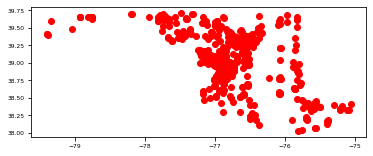

In [ ]:
workWithGeometryData( 'pandp', points, gdf)

Looking good! But the red dots are a bit too noisy. Lets create a choropleth instead!

We can start of by finding which points are inside of which polygons!

In [ ]:
points.columns
gdf.columns

Index(['X', 'Y', 'OBJECTID', 'Name', 'Address', 'City_1', 'State', 'Zip',
       '# in Zip', 'FIPS', 'geometry'],
      dtype='object')

Index(['OBJECTID', 'CSA2010', 'tpop10', 'male10', 'female10', 'paa17',
       'pwhite17', 'pasi17', 'p2more17', 'ppac17', 'phisp17', 'racdiv17',
       'age5_17', 'age18_17', 'age24_17', 'age64_17', 'age65_17', 'hhs10',
       'femhhs17', 'fam17', 'hhsize10', 'mhhi17', 'hh25inc17', 'hh40inc17',
       'hh60inc17', 'hh75inc17', 'hhm7517', 'hhpov17', 'hhchpov17',
       'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')

a choropleth map is created at the bottom of the output once the the code below this cell is exectued for our Food Pantries Data.

In [ ]:
# https://stackoverflow.com/questions/27606924/count-number-of-points-in-multipolygon-shapefile-using-python
ptsCoordCol = 'geometry'
polygonsCoordCol = 'geometry'

pointsInPolysChloro = workWithGeometryData('pinp', points, gdf, 'geometry' , 'geometry')

# And now that we have that settled, lets map it!

pointsInPolysChloro.plot( column='number of points', legend=True)

Alternately, we could map the centroid of boundaries within another boundary to find boundaries within boundaries